In [1]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_test_models/SimpleRNN_test_model.h5')

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm
from scipy.linalg import fractional_matrix_power

# pauli matrix
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])

# Detunning Factor
d0 = 0.15
v0 = 0.02

def Rx(theta):
    return np.matrix([[cos(theta/2),     -1j*sin(theta/2)],
                    [-1j*sin(theta/2),     cos(theta/2)]])

def Rz(phi): # Rz는 사용하지 않음. 해밀토니안에 의한 회전으로만 컨트롤
    return np.matrix([[cos(phi/2)-1j*sin(phi/2),       0],
                     [0,                          cos(phi/2)+1j*sin(phi/2)]])

def unitary(dt, choice) :
    choice_list = [0,1,-1,1,-1] # x,y-rotiation 방향 선택
    if choice <3 :
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else :
        Ham = (d0*sz+v0*choice_list[choice]*sy)
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    return U_e

def state_fidelity(rho_1, rho_2): 
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)




init_wave = np.array([[1],[0]])
irho_init = np.kron(init_wave,init_wave.conj().T)

def fidelity(target_theta,target_phi) :
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @target_U.conj().T

    # 모델로 예측
    new_theta = np.array(target_theta).reshape(-1,1)
    new_phi = np.array(target_phi).reshape(-1,1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    # 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)


    Uni = s0
    U_0 = unitary(2.6,0)
    U_1 = unitary(2.6,1)
    U_2 = unitary(2.6,2)
    U_3 = unitary(2.6,3)
    U_4 = unitary(2.6,4)
    pulse_list = [U_0,U_1,U_2,U_3,U_4]
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     # 새로운 theta와 phi 값 정의
     #target_theta = np.pi/180*random.uniform(0,180)  # 예시 값
     target_theta = np.pi/180*random.uniform(0,180)
     target_phi = np.pi/180*random.uniform(0,360)   # 예시 값
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     sum += temp
print(sum/iter)

1/1 [==============================] - 0s 50ms/step
0.9902549485509404


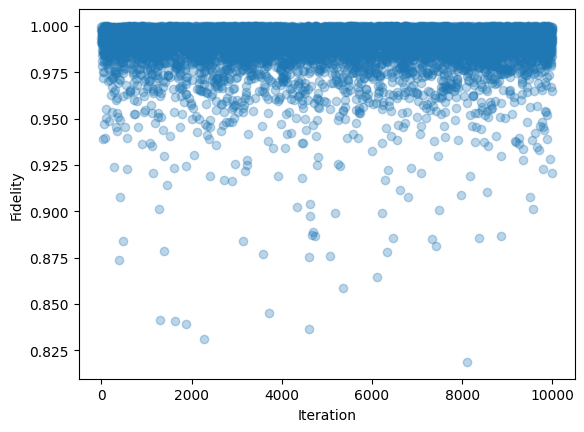

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

9 0.9841688721049647
14 0.9813040866601482
16 0.9899582801663382
17 0.9867726375577078
20 0.978473550948679
31 0.9876302734980582
36 0.9860982411801191
37 0.974898119962199
38 0.9390849658132051
47 0.9721023346222266
49 0.9854069305267061
54 0.9750931320366935
55 0.9799940149983961
59 0.9847975563454795
60 0.9896516097901078
62 0.9814804942625309
65 0.9470892301956967
66 0.9850768138543118
69 0.984359736192359
70 0.9876311826259123
71 0.9861109952054996
74 0.9859472703927313
75 0.9394020291076604
78 0.983887598330748
86 0.9879839919810117
99 0.9859345931560856
100 0.9806846985414411
102 0.989793351624061
104 0.9888634850049292
105 0.9505322315112174
109 0.9551088803858192
113 0.9862288487015403
114 0.9886348371062833
116 0.979696466383328
117 0.9878591393359493
128 0.9860234119526207
130 0.9899805201543888
136 0.9809350617827628
138 0.9833698760585866
142 0.9860627829662704
143 0.9773499393931208
149 0.9850005824108097
151 0.9851047320455538
153 0.9899175331904593
154 0.970085063808200

In [6]:
print(low_fidelities)
print(low_fidelities['theta'])

{'theta': [2.974381786217484, 2.0002872228112785, 0.5718328770683216, 2.773972206293356, 1.0827961155580301, 0.38413932605289974, 0.3804624053506046, 1.7863881705661713, 3.074440620773728, 1.5497672893303271, 2.2768581133558334, 1.639089905126152, 2.432963602188004, 2.126217811628391, 0.26830904239536835, 1.1434668418058576, 2.8725845502623635, 1.7795249130526605, 1.9058072904667345, 1.4564929343407176, 2.5904445480552054, 1.7839762545817965, 1.9343740224255814, 1.3740466771898527, 0.3993725957249211, 1.4624970298607234, 1.0787085819467157, 1.1309002509072676, 2.9973353584578706, 2.0061445201666266, 1.471639982150361, 2.043669436269869, 0.4007375651025395, 1.880009756729079, 2.43165286299656, 0.32205603855071424, 1.2387129672330957, 0.5643141089034504, 1.3046194013060342, 1.6675790649703046, 2.2010044377872244, 1.3808128268568154, 1.4254308853206006, 0.20116198040842595, 1.3647560748006278, 1.39449601759729, 2.8687718707376932, 1.4076199101332665, 2.30922439223637, 3.043609241444011, 0

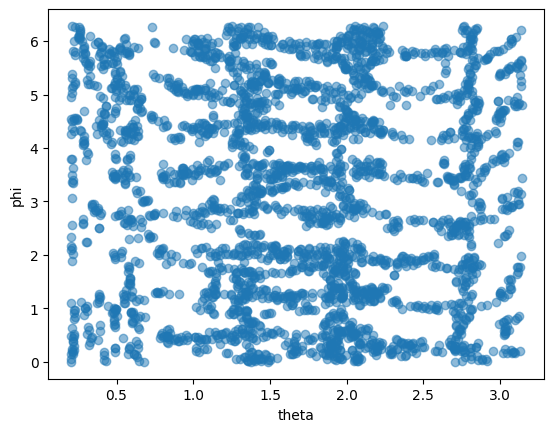

In [7]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()